# **유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, GlobalMaxPool1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [6]:
# Train Data
sales_train = pd.read_csv('./train/sales_train.csv')  # 판매 정보
products_train = pd.read_csv('./train/products.csv')  # 상품 기본 정보
stores_train = pd.read_csv('./train/stores.csv')  # 매장 기본 정보
orders_train = pd.read_csv('./train/orders_train.csv')  # 일별 매장별 고객 방문 수
oil_price_train = pd.read_csv('./train/oil_price_train.csv')  # 일별 유가(WTI: 서부텍사스유)

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [9]:
def make_3d_train_data(sales, orders, oil_price, products, stores, p_id, y_scale_option, ts_1):
    # to_datetime()
    sales['Date'] = pd.to_datetime(sales['Date'])
    oil_price['Date'] = pd.to_datetime(oil_price['Date'])
    orders['Date'] = pd.to_datetime(orders['Date'])
    
    # -------------------- Make Dataset --------------------
    
    def make_dataset(Product_ID):
        # 1. 대상 매장(44), 대상 상품(Product_ID) Filtering
        LeadTime = products.loc[products['Product_ID'] == Product_ID, 'LeadTime'].values[0]
        temp1 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID), ['Date','Qty']]
        temp2 = orders.loc[orders['Store_ID'] == 44, ['Date','CustomerCount']]
        temp3 = pd.merge(temp1, temp2, how='inner', on='Date')
        temp3['target'] = temp3['Qty'].shift(-LeadTime)
        temp3.dropna(inplace=True)

        # 2. Feature Engineering
        # 2.1 날짜 요소 추출
        temp3['WeekDay'] = temp3['Date'].dt.day_name()
        temp3['Month'] = temp3['Date'].dt.month

        # 2.2 동일 카테고리 판매량 합계
        Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()  # to_list(): Series의 values를 리스트로 변환
        Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
        temp4 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index=False)['Qty'].sum()
        temp4.columns = ['Date', 'Category_Qty']
        temp3 = pd.merge(temp3, temp4, how='left', on='Date')

        # 2.3 동일 지역 방문객 수
        City = stores.loc[stores['Store_ID'] == 44, 'City'].values[0]
        Store_IDs = stores.loc[stores['City'] == City, 'Store_ID'].to_list()
        temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index=False)['CustomerCount'].sum()
        temp5.columns = ['Date', 'City_CustCount']
        temp3 = pd.merge(temp3, temp5, how='left', on='Date')

        # 2.4 oil price MA14
        temp3 = pd.merge(temp3, oil_price, how='left', on='Date')
        temp3['WTI_Price'] = temp3['WTI_Price'].rolling(window=14, min_periods=1).mean()  # 유가는 14일 이동평균으로 대체

        # 2.5 Qty MA7
        temp3['Qty_MA7'] = temp3['Qty'].rolling(window=7, min_periods=1).mean()

        # 2.6 Seasonal
        decomp7 = sm.tsa.seasonal_decompose(temp3['Qty'], model='additive', period=7)
        temp3['Qty_Seasonal7'] = decomp7.seasonal

        return temp3

    data_target_product = make_dataset(p_id)

    # -------------------- Preprocess --------------------

    def preprocessing_3d(data, ts_2, y_scale=False):

        # 2차원 --> 3차원 변환
        def temporalize(x, y, timesteps):
            output_X = []
            output_y = []
            for i in range(len(x) - timesteps + 1):
                output_X.append(x.iloc[i:i + timesteps])
                output_y.append(y.iloc[i + timesteps - 1])
            return np.array(output_X), np.array(output_y)
        
        target = 'target'
        # x, y 분할
        x = data.drop(['Date', target], axis=1)
        y = data.loc[:, target]

        # 가변수화
        x['WeekDay'] = pd.Categorical(x['WeekDay'], categories=['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])  # 명시적인 순서 정보
        x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        x = pd.get_dummies(x, columns=['WeekDay', 'Month'], drop_first=True, dtype=int)
        col_names = list(x)

        # x scale (2차원 scale -> 3차원 변환 위해 scale된 dataframe)
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x)
        x = pd.DataFrame(x, columns=col_names)

        # y scale
        if y_scale == True:
            y_min, y_max = y.min(), y.max()
            y = (y - y_min) / (y_max - y_min)  # MinMaxScaling
        else:
            y_min, y_max = np.nan, np.nan

        # 3차원 변환
        x3, y3 = temporalize(x, y, ts_2)

        # train, val set
        val_size = 120
        x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size=val_size, shuffle=False)

        return x_train, x_val, y_train, y_val, scaler, y_min, y_max
    
    return preprocessing_3d(data_target_product, ts_1, y_scale_option)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

In [18]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = make_3d_train_data(sales_train, orders_train, oil_price_train, products_train, stores_train, 3, True, 7)
x_train.shape

(1018, 7, 24)

In [19]:
clear_session()

timesteps, nfeatures = x_train.shape[1], x_train.shape[2]

model03_00 = Sequential()

model03_00.add(LSTM(64, input_shape=(timesteps, nfeatures), activation='relu', return_sequences=True))
model03_00.add(LSTM(32, activation='relu', return_sequences=True))
model03_00.add(LSTM(16, activation='relu', return_sequences=True))
model03_00.add(LSTM(8, activation='relu', return_sequences=True))
model03_00.add(LSTM(4, activation='relu', return_sequences=False))
model03_00.add(Dense(1))

model03_00.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model03_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 7, 8)                │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,349 (153.71 KB)

 Trainable params: 39,349 (153.71 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model03_00.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0, callbacks=[es]).history

In [22]:
pred = model03_00.predict(x_val)  # 모델은 scale된 y_train 기준으로 학습함
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', mean_squared_error(y_val2, pred, squared=False))
print('MAE: ', mean_absolute_error(y_val2, pred))
print('MAPE: ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step
RMSE:  2333.5766924755458
MAE:  1645.2909342447917
MAPE:  0.1378931268821067
R2 :  0.5446550806841808


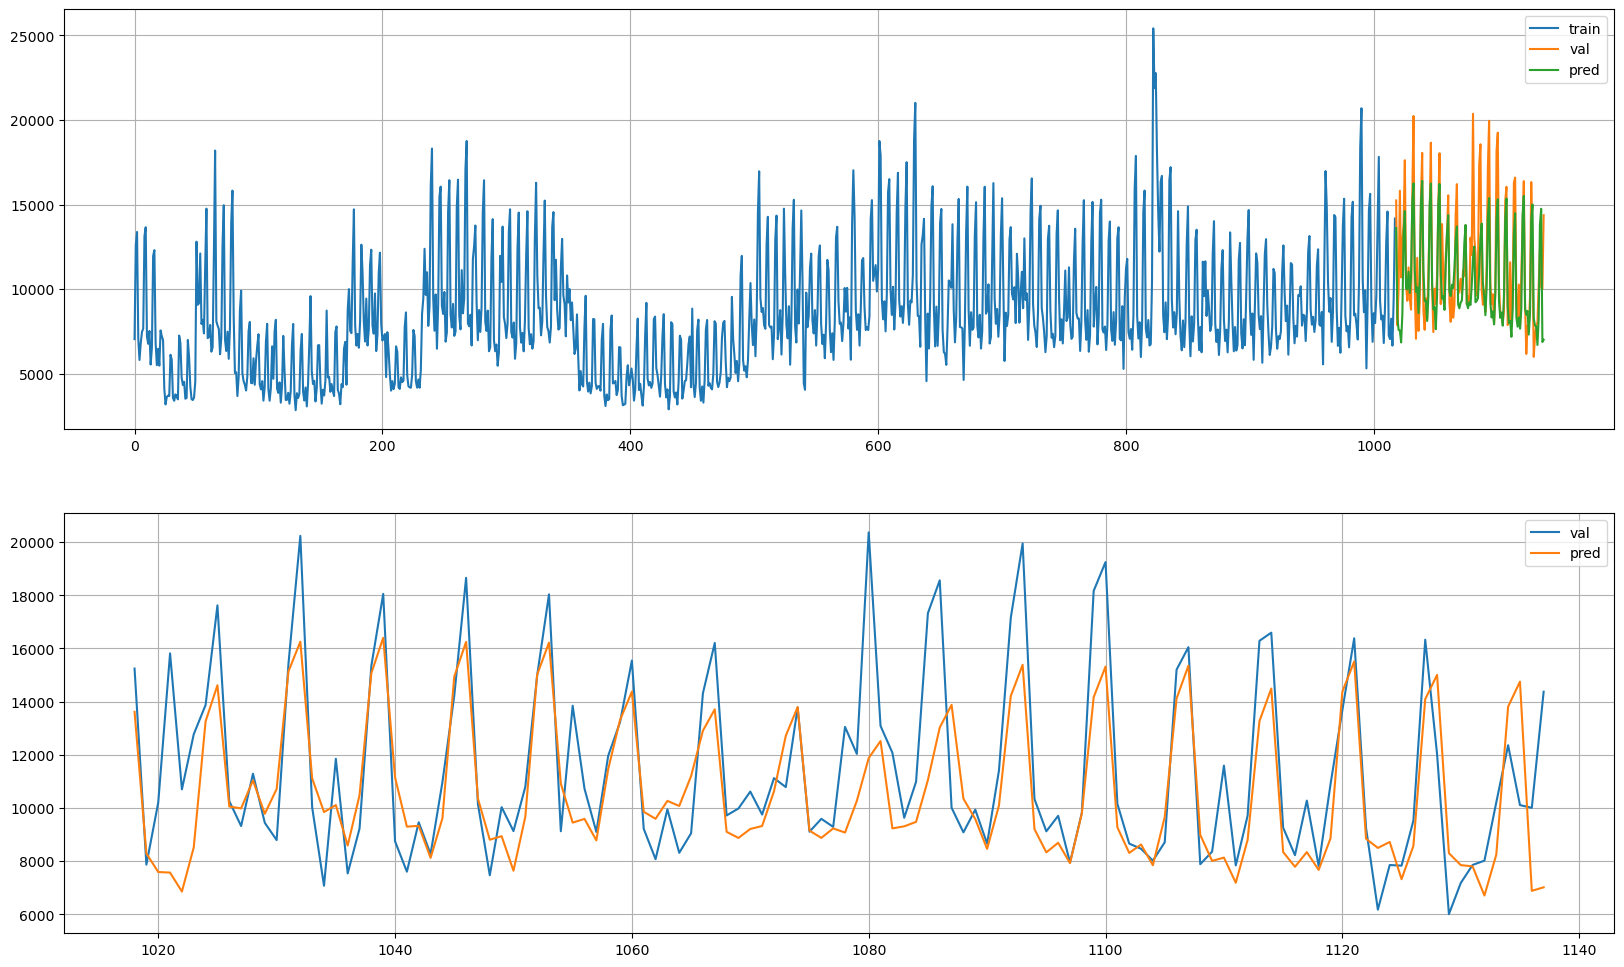

In [23]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

In [24]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = make_3d_train_data(sales_train, orders_train, oil_price_train, products_train, stores_train, 12, True, 7)
x_train.shape

(1018, 7, 24)

In [26]:
clear_session()

timesteps, nfeatures = x_train.shape[1], x_train.shape[2]

model12_00 = Sequential()

model12_00.add(LSTM(64, input_shape=(timesteps, nfeatures), activation='relu', return_sequences=True))
model12_00.add(LSTM(32, activation='relu', return_sequences=True))
model12_00.add(LSTM(16, activation='relu', return_sequences=True))
model12_00.add(LSTM(8, activation='relu', return_sequences=True))
model12_00.add(LSTM(4, activation='relu', return_sequences=False))
model12_00.add(Dense(1))

model12_00.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model12_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 7, 8)                │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,349 (153.71 KB)

 Trainable params: 39,349 (153.71 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model12_00.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0, callbacks=[es]).history

In [29]:
pred = model12_00.predict(x_val)  # 모델은 scale된 y_train 기준으로 학습함
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', mean_squared_error(y_val2, pred, squared=False))
print('MAE: ', mean_absolute_error(y_val2, pred))
print('MAPE: ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE:  2626.378346358755
MAE:  2011.0297119140625
MAPE:  0.15191423433746226
R2 :  0.46454549553361146


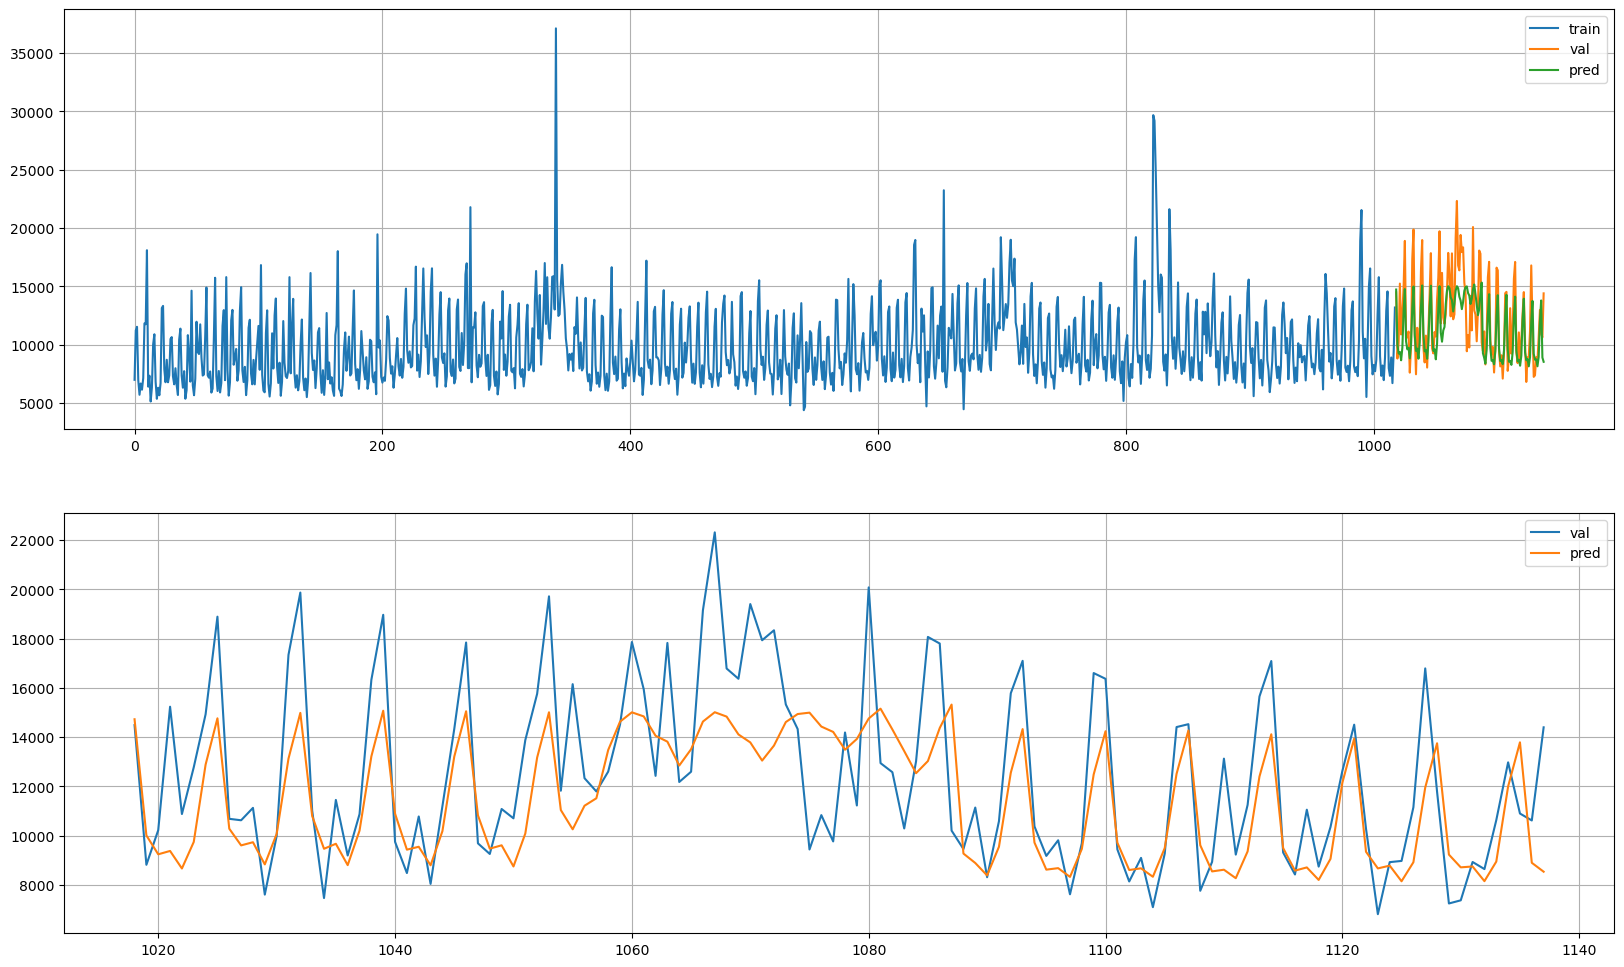

In [30]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

In [32]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = make_3d_train_data(sales_train, orders_train, oil_price_train, products_train, stores_train, 42, True, 7)
x_train.shape

(1018, 7, 24)

In [33]:
clear_session()

timesteps, nfeatures = x_train.shape[1], x_train.shape[2]

model42_00 = Sequential()

model42_00.add(LSTM(64, input_shape=(timesteps, nfeatures), activation='relu', return_sequences=True))
model42_00.add(LSTM(32, activation='relu', return_sequences=True))
model42_00.add(LSTM(16, activation='relu', return_sequences=True))
model42_00.add(LSTM(8, activation='relu', return_sequences=True))
model42_00.add(LSTM(4, activation='relu', return_sequences=False))
model42_00.add(Dense(1))

model42_00.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model42_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 7, 8)                │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 4)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,349 (153.71 KB)

 Trainable params: 39,349 (153.71 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model42_00.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0, callbacks=[es]).history

In [35]:
pred = model42_00.predict(x_val)  # 모델은 scale된 y_train 기준으로 학습함
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', mean_squared_error(y_val2, pred, squared=False))
print('MAE: ', mean_absolute_error(y_val2, pred))
print('MAPE: ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step
RMSE:  15.7397283987537
MAE:  12.368062273661296
MAPE:  0.12774386982446578
R2 :  0.5423877852624184


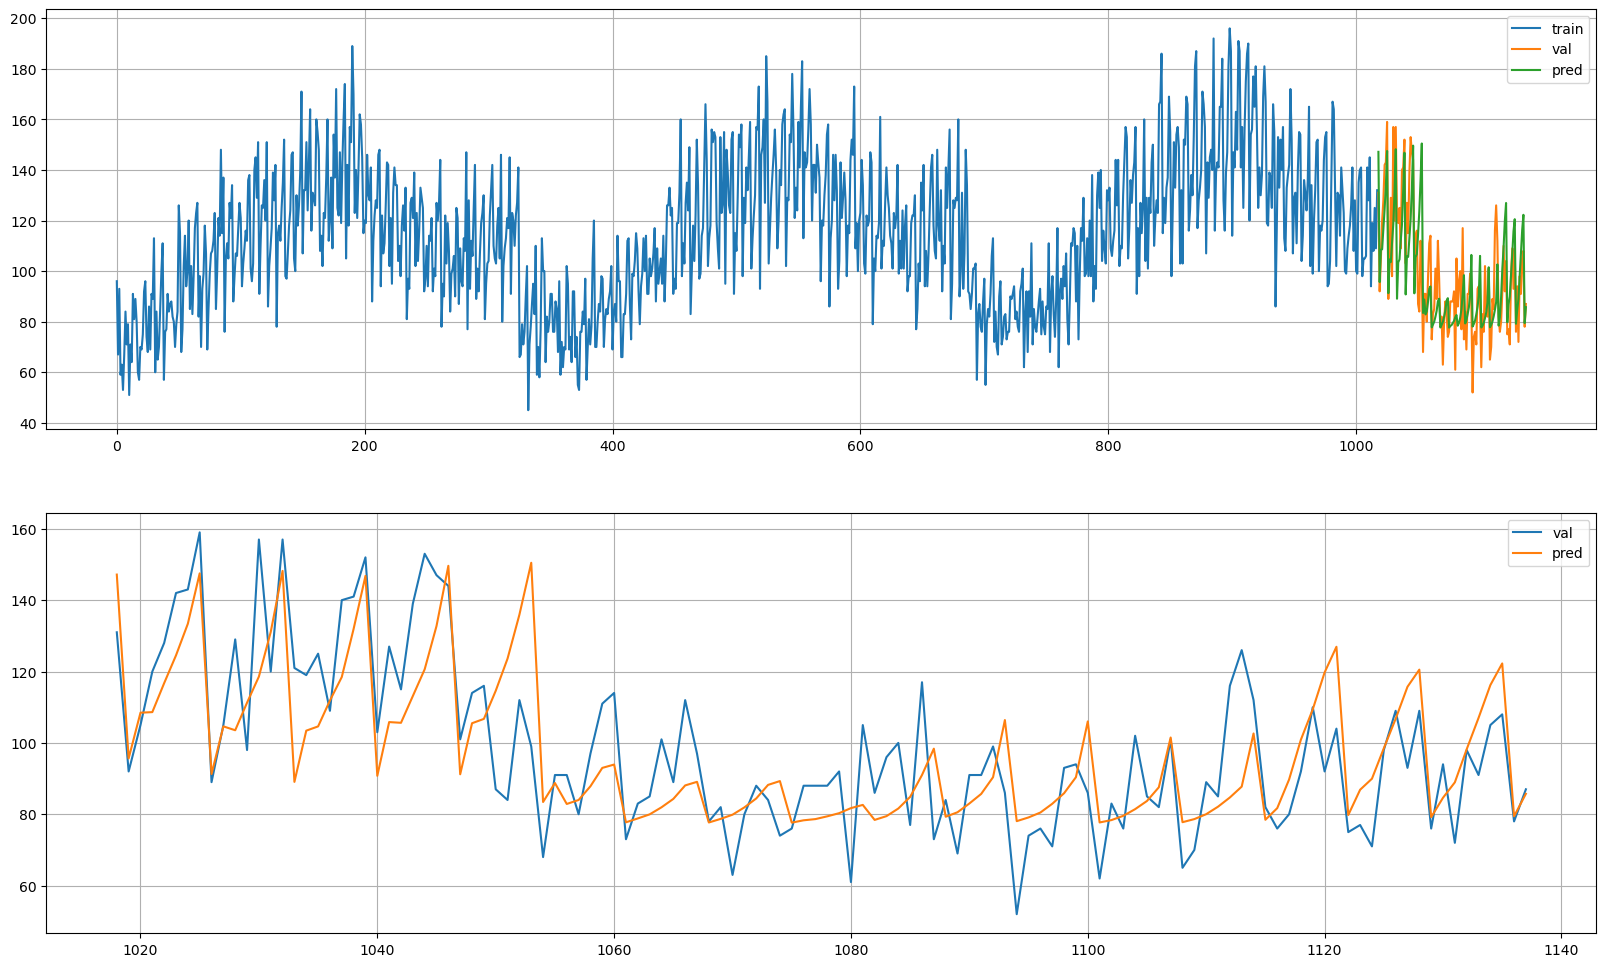

In [36]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

In [37]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = make_3d_train_data(sales_train, orders_train, oil_price_train, products_train, stores_train, 3, True, 7)
x_train.shape

(1018, 7, 24)

In [41]:
clear_session()

timesteps, nfeatures = x_train.shape[1], x_train.shape[2]

model03_01 = Sequential()

model03_01.add(Conv1D(64, 5, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model03_01.add(Conv1D(32, 5, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model03_01.add(Conv1D(16, 10, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model03_01.add(Conv1D(8, 15, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model03_01.add(GlobalMaxPool1D())
model03_01.add(Dense(16))
model03_01.add(Dense(1))

model03_01.compile(optimizer=Adam(learning_rate = 0.01), loss='mse')
model03_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 64)               │           7,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 16)               │           5,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 7, 8)                │           1,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 8)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,241 (98.60 KB)

 Trainable params: 25,241 (98.60 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model03_01.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0, callbacks=[es]).history

In [43]:
pred = model03_01.predict(x_val)  # 모델은 scale된 y_train 기준으로 학습함
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', mean_squared_error(y_val2, pred, squared=False))
print('MAE: ', mean_absolute_error(y_val2, pred))
print('MAPE: ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
RMSE:  2463.753097808947
MAE:  1986.911181640625
MAPE:  0.16994514144478354
R2 :  0.4924361243090445


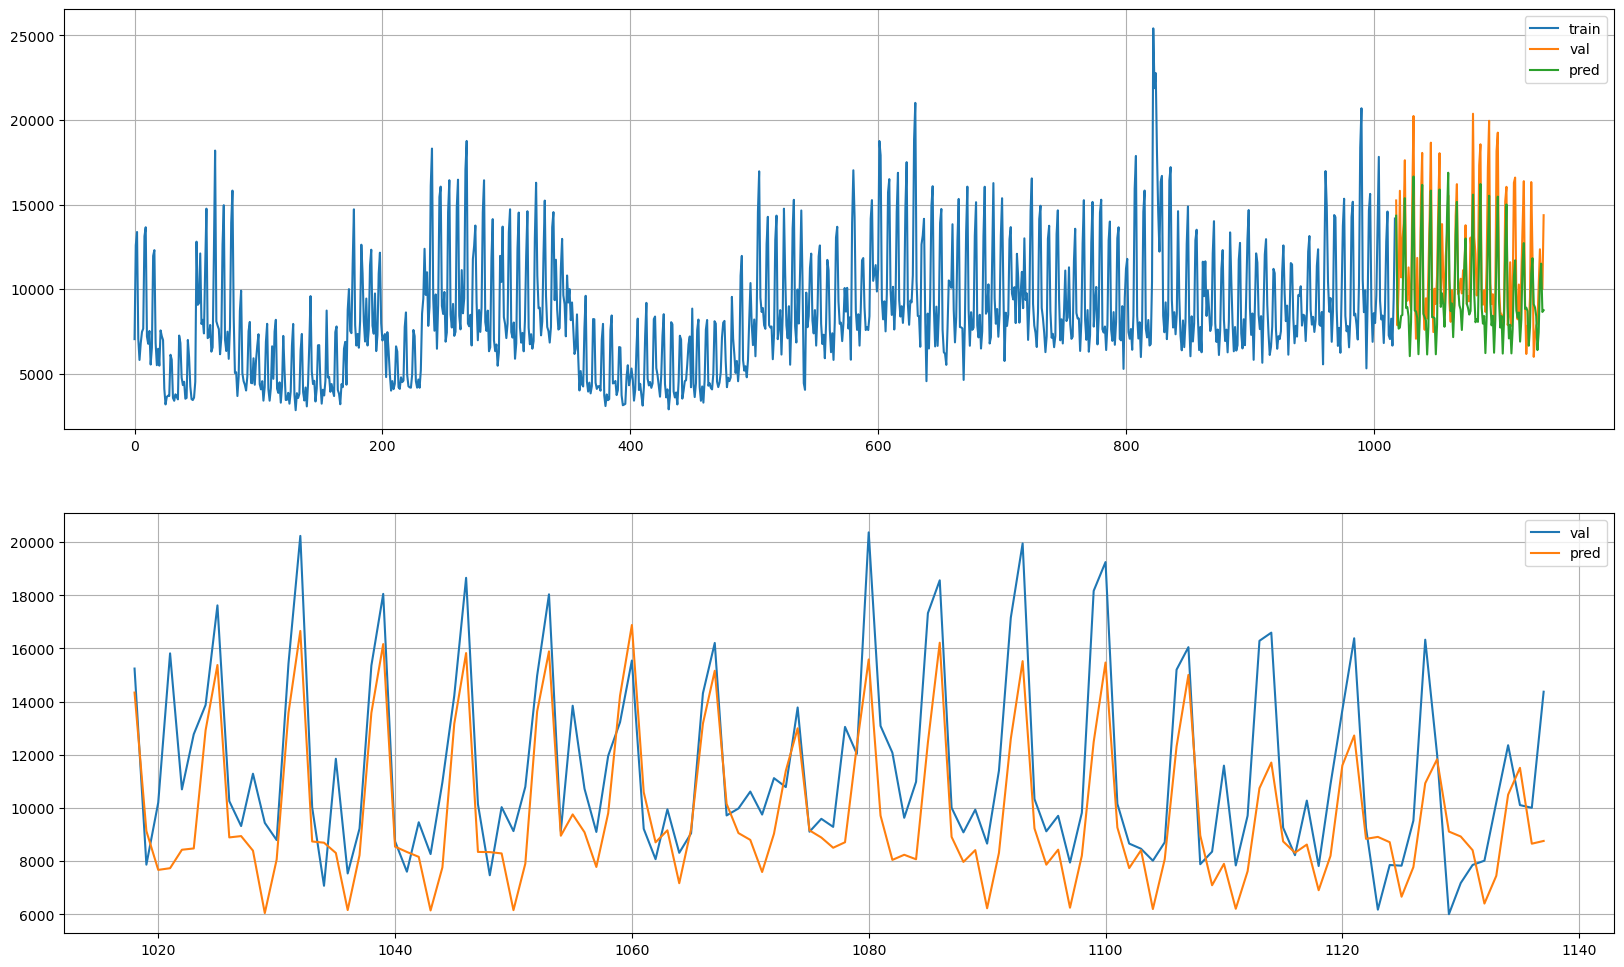

In [44]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

In [45]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = make_3d_train_data(sales_train, orders_train, oil_price_train, products_train, stores_train, 12, True, 7)
x_train.shape

(1018, 7, 24)

In [46]:
clear_session()

timesteps, nfeatures = x_train.shape[1], x_train.shape[2]

model12_01 = Sequential()

model12_01.add(Conv1D(64, 5, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model12_01.add(Conv1D(32, 5, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model12_01.add(Conv1D(16, 10, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model12_01.add(Conv1D(8, 15, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model12_01.add(GlobalMaxPool1D())
model12_01.add(Dense(16))
model12_01.add(Dense(1))

model12_01.compile(optimizer=Adam(learning_rate = 0.01), loss='mse')
model12_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 64)               │           7,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 16)               │           5,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 7, 8)                │           1,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 8)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,241 (98.60 KB)

 Trainable params: 25,241 (98.60 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model12_01.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0, callbacks=[es]).history

In [48]:
pred = model12_01.predict(x_val)  # 모델은 scale된 y_train 기준으로 학습함
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', mean_squared_error(y_val2, pred, squared=False))
print('MAE: ', mean_absolute_error(y_val2, pred))
print('MAPE: ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
RMSE:  2893.962463192761
MAE:  2230.3174845377603
MAPE:  0.16603935660198696
R2 :  0.34987961248588595


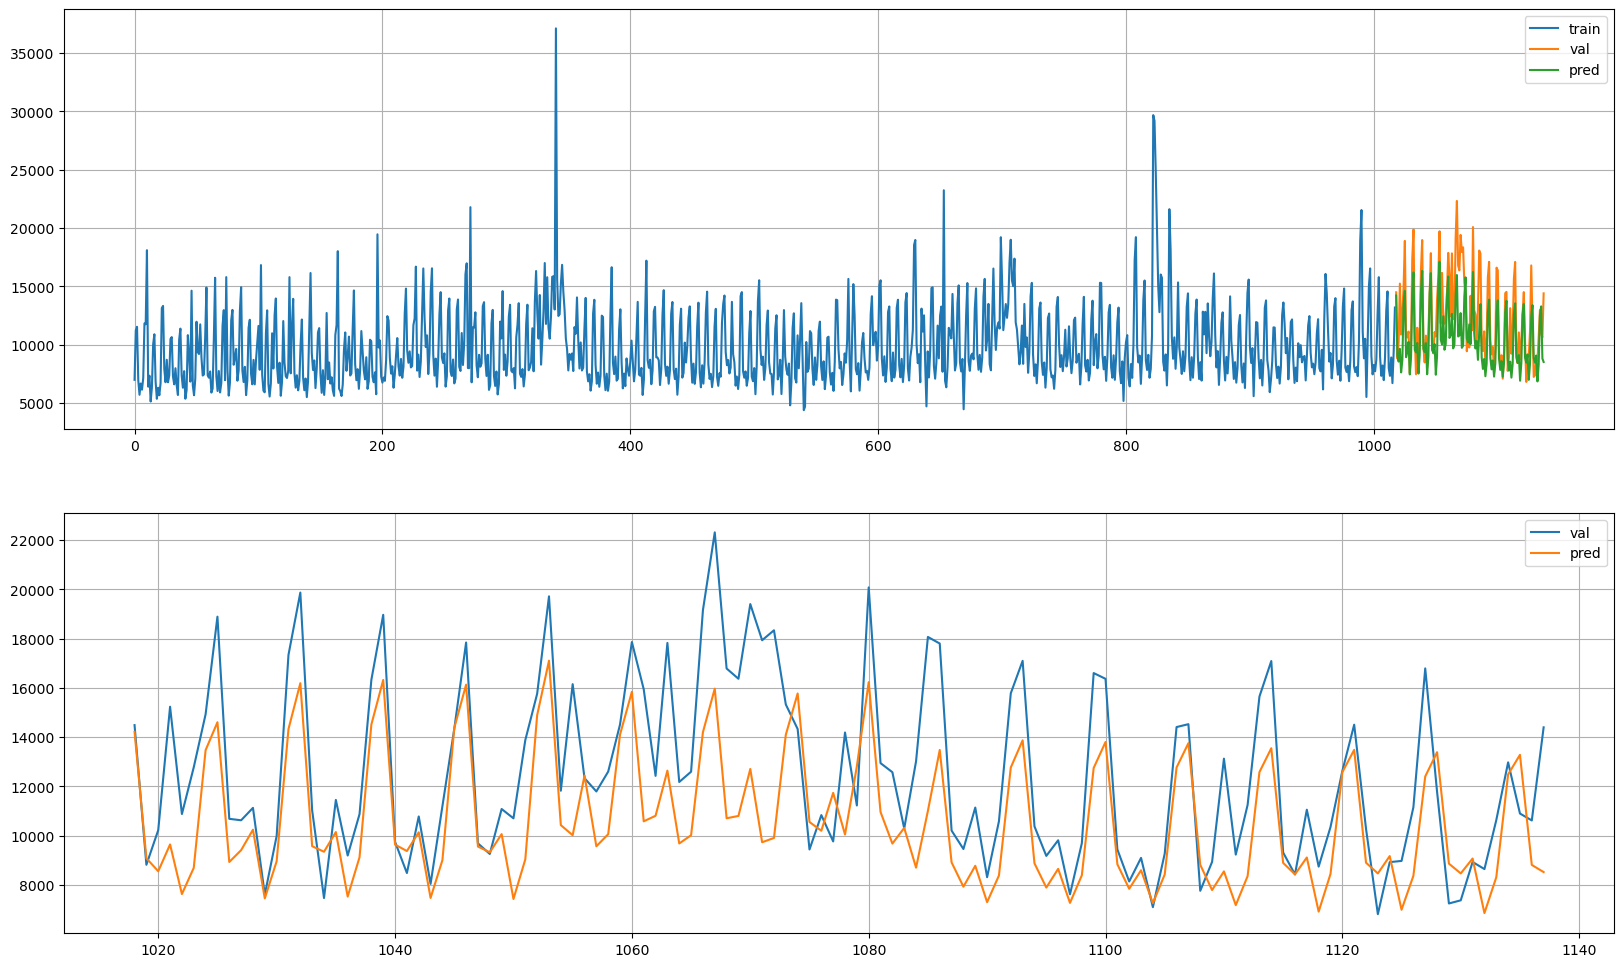

In [49]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

In [50]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = make_3d_train_data(sales_train, orders_train, oil_price_train, products_train, stores_train, 42, True, 7)
x_train.shape

(1018, 7, 24)

In [51]:
clear_session()

timesteps, nfeatures = x_train.shape[1], x_train.shape[2]

model42_01 = Sequential()

model42_01.add(Conv1D(64, 5, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model42_01.add(Conv1D(32, 5, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model42_01.add(Conv1D(16, 10, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model42_01.add(Conv1D(8, 15, input_shape=(timesteps, nfeatures), activation='relu', padding='same'))
model42_01.add(GlobalMaxPool1D())
model42_01.add(Dense(16))
model42_01.add(Dense(1))

model42_01.compile(optimizer=Adam(learning_rate = 0.01), loss='mse')
model42_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 64)               │           7,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 16)               │           5,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 7, 8)                │           1,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 8)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,241 (98.60 KB)

 Trainable params: 25,241 (98.60 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model42_01.fit(x_train, y_train, epochs=300, validation_split=0.2, verbose=0, callbacks=[es]).history

In [53]:
pred = model42_01.predict(x_val)  # 모델은 scale된 y_train 기준으로 학습함
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', mean_squared_error(y_val2, pred, squared=False))
print('MAE: ', mean_absolute_error(y_val2, pred))
print('MAPE: ', mean_absolute_percentage_error(y_val2, pred))
print('R2 : ', r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
RMSE:  14.223464197751634
MAE:  11.075842030843098
MAPE:  0.11586012002449966
R2 :  0.6263079074488538


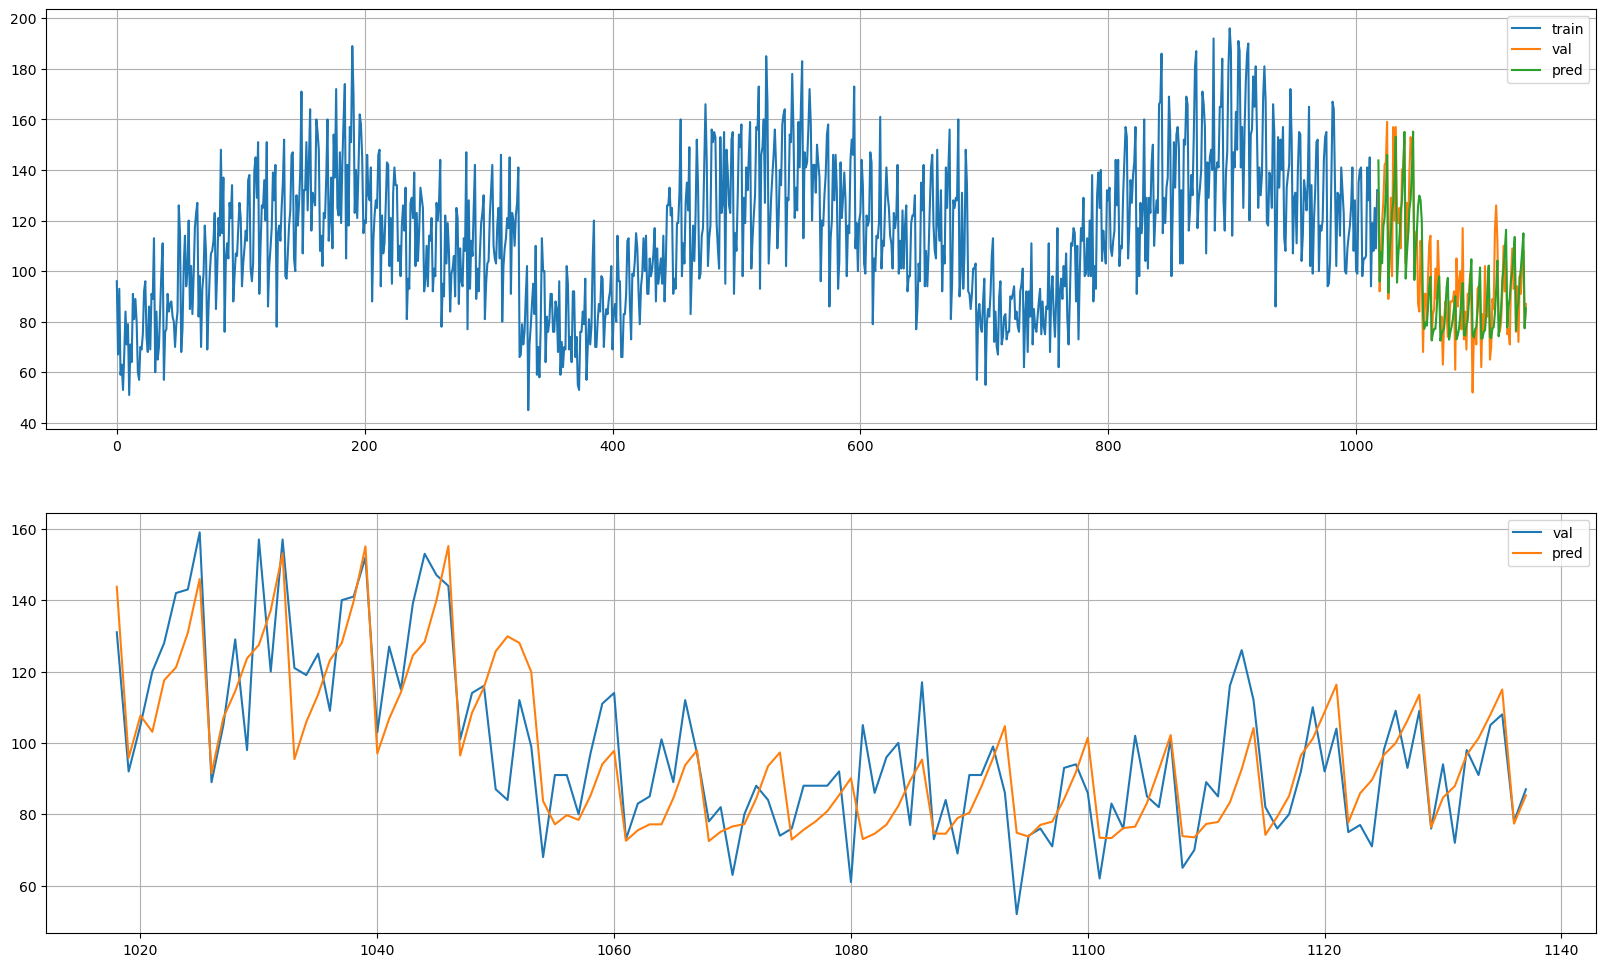

In [54]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(1) 파이프라인 함수 생성**

In [56]:
# Test Data
sales_test = pd.read_csv('./test/sales_test.csv')  # 판매 정보
products_test = pd.read_csv('./test/products.csv')  # 상품 기본 정보
stores_test = pd.read_csv('./test/stores.csv')  # 매장 기본 정보
orders_test = pd.read_csv('./test/orders_test.csv')  # 일별 매장별 고객 방문 수
oil_price_test = pd.read_csv('./test/oil_price_test.csv')  # 일별 유가(WTI: 서부텍사스유)

In [57]:
def make_3d_test_data(sales, orders, oil_price, products, stores, p_id, y_scale_option, ts_1, train_scaler, train_y_min, train_y_max):
    # to_datetime()
    sales['Date'] = pd.to_datetime(sales['Date'])
    oil_price['Date'] = pd.to_datetime(oil_price['Date'])
    orders['Date'] = pd.to_datetime(orders['Date'])
    
    # -------------------- Make Dataset --------------------
    
    def make_dataset(Product_ID):
        # 1. 대상 매장(44), 대상 상품(Product_ID) Filtering
        LeadTime = products.loc[products['Product_ID'] == Product_ID, 'LeadTime'].values[0]
        temp1 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID), ['Date','Qty']]
        temp2 = orders.loc[orders['Store_ID'] == 44, ['Date','CustomerCount']]
        temp3 = pd.merge(temp1, temp2, how='inner', on='Date')
        temp3['target'] = temp3['Qty'].shift(-LeadTime)
        temp3.dropna(inplace=True)

        # 2. Feature Engineering
        # 2.1 날짜 요소 추출
        temp3['WeekDay'] = temp3['Date'].dt.day_name()
        temp3['Month'] = temp3['Date'].dt.month

        # 2.2 동일 카테고리 판매량 합계
        Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()  # to_list(): Series의 values를 리스트로 변환
        Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
        temp4 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index=False)['Qty'].sum()
        temp4.columns = ['Date', 'Category_Qty']
        temp3 = pd.merge(temp3, temp4, how='left', on='Date')

        # 2.3 동일 지역 방문객 수
        City = stores.loc[stores['Store_ID'] == 44, 'City'].values[0]
        Store_IDs = stores.loc[stores['City'] == City, 'Store_ID'].to_list()
        temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index=False)['CustomerCount'].sum()
        temp5.columns = ['Date', 'City_CustCount']
        temp3 = pd.merge(temp3, temp5, how='left', on='Date')

        # 2.4 oil price MA14
        temp3 = pd.merge(temp3, oil_price, how='left', on='Date')
        temp3['WTI_Price'] = temp3['WTI_Price'].rolling(window=14, min_periods=1).mean()  # 유가는 14일 이동평균으로 대체

        # 2.5 Qty MA7
        temp3['Qty_MA7'] = temp3['Qty'].rolling(window=7, min_periods=1).mean()

        # 2.6 Seasonal
        decomp7 = sm.tsa.seasonal_decompose(temp3['Qty'], model='additive', period=7)
        temp3['Qty_Seasonal7'] = decomp7.seasonal

        return temp3

    data_target_product = make_dataset(p_id)

    # -------------------- Preprocess --------------------

    def preprocessing_3d(data, ts_2, scaler, y_min, y_max, y_scale=False):

        # 2차원 --> 3차원 변환
        def temporalize(x, y, timesteps):
            output_X = []
            output_y = []
            for i in range(len(x) - timesteps + 1):
                output_X.append(x.iloc[i:i + timesteps])
                output_y.append(y.iloc[i + timesteps - 1])
            return np.array(output_X), np.array(output_y)
        
        target = 'target'
        # x, y 분할
        x = data.drop(['Date', target], axis=1)
        y = data.loc[:, target]

        # 가변수화
        x['WeekDay'] = pd.Categorical(x['WeekDay'], categories=['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])  # 명시적인 순서 정보
        x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        x = pd.get_dummies(x, columns=['WeekDay', 'Month'], drop_first=True, dtype=int)
        col_names = list(x)

        # x scale (2차원 scale -> 3차원 변환 위해 scale된 dataframe)
        x = scaler.transform(x)
        x = pd.DataFrame(x, columns=col_names)

        # y scale
        if y_scale == True:
            y = (y - y_min) / (y_max - y_min)  # MinMaxScaling

        # 3차원 변환
        x3, y3 = temporalize(x, y, ts_2)

        return x3, y3
    
    return preprocessing_3d(data_target_product, ts_1, train_scaler, train_y_min, train_y_max, y_scale_option)

In [61]:
x_test, y_test = make_3d_test_data(sales_test, orders_test, oil_price_test, products_test, stores_test, 3, True, 7, scaler, y_min, y_max)
print(x_test.shape, y_test.shape)

(23, 7, 24) (23,)


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [60]:
def inv_simulator(y, pred, safe_stock, price):

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [62]:
pred = model03_00.predict(x_test)
pred = pred * (y_max - y_min) + y_min

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


In [83]:
inv_simulator(y_test, pred, 161, 8)

일평균 재고량     : 229.062
일평균 재고 금액  : 1832.496
일평균 재고회전율 : 0.476
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,58.086093,101.0,219.086093,161,102,58.086093,0.0
1,66.503311,108.0,227.503311,161,56,66.503311,0.0
2,99.907285,102.0,263.000000,163,99,102.000000,0.0
3,122.589404,56.0,219.000000,96,165,56.000000,0.0
4,58.000000,101.0,195.000000,137,80,99.000000,0.0
5,57.251656,100.0,302.000000,245,17,165.000000,0.0
6,60.622517,56.0,325.000000,264,0,80.000000,0.0
7,53.662252,101.0,281.000000,227,33,17.000000,0.0
8,76.629139,101.0,227.000000,150,67,0.000000,0.0
9,109.039735,99.0,183.000000,74,143,33.000000,0.0
